In [19]:
import os
from collections import Counter

data_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

class_counts = {}

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

total_images = sum(class_counts.values())

class_proportions = {class_name: count / total_images for class_name, count in class_counts.items()}

print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")

Class Proportions:
tomato_fully_ripened: 0.01
tomato_half_ripened: 0.01
banana_overripe: 0.21
banana_rotten: 0.30
banana_unripe: 0.21
banana_ripe: 0.22
tomato_green: 0.05


## ViT Model in tensorflow

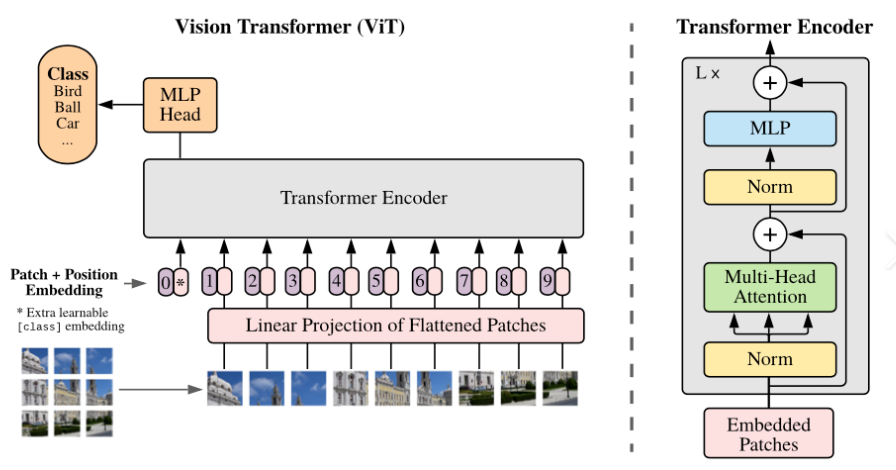

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, Model
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

In [23]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
IMG_SIZE = (224, 224)
PATCH_SIZE = 16
PROJECTION_DIM = 128
NUM_HEADS = 8
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]
DROPOUT_RATE = 0.1

# Custom Layers for Vision Transformer
class PatchCreation(layers.Layer):
    def __init__(self, patch_size):
        super(PatchCreation, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(projection_dim)
        
    def call(self, patches):
        return self.projection(patches)

class PositionEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PositionEmbedding, self).__init__()
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        
    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = patches + self.position_embedding(positions)
        return encoded

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout
        )
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.mlp = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])
        
    def call(self, inputs, training=True):
        # Apply Layer Normalization before attention
        x1 = self.layernorm1(inputs)
        attention_output = self.attention(x1, x1, training=training)
        x2 = attention_output + inputs
        
        # Apply Layer Normalization before MLP
        x3 = self.layernorm2(x2)
        x4 = self.mlp(x3, training=training)
        return x2 + x4

# Main Vision Transformer Model
def create_vit_model(input_shape, patch_size, num_classes, projection_dim, 
                     num_heads, transformer_layers, mlp_head_units, dropout=0.1):
    # Calculate number of patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    inputs = layers.Input(shape=input_shape)
    
    # No normalization layer since we already normalized in generator
    # Create patches from images
    patches = PatchCreation(patch_size)(inputs)
    
    # Create patch embeddings
    embedding_layer = PatchEmbedding(num_patches, projection_dim)
    embeddings = embedding_layer(patches)
    
    # Add positional embeddings
    position_embedding = PositionEmbedding(num_patches, projection_dim)
    encoded_patches = position_embedding(embeddings)
    
    # Add dropout after embeddings
    x = layers.Dropout(dropout)(encoded_patches)
    
    # Create Transformer Encoder blocks
    for _ in range(transformer_layers):
        x = TransformerEncoderBlock(
            projection_dim, num_heads, projection_dim * 4, dropout
        )(x)
    
    # Layer Normalization and Global Average Pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(x)
    representation = layers.GlobalAvgPool1D()(representation)
    
    # MLP Head for classification
    features = representation
    for units in mlp_head_units:
        features = layers.Dense(units, activation="gelu")(features)
        features = layers.Dropout(dropout)(features)
    
    # Final classification layer
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to handle class imbalance
def calculate_class_weights(generator):
    # Get labels from generator
    y = []
    num_samples = 0
    
    for i in range(len(generator)):
        if num_samples >= generator.samples:
            break
        batch_x, batch_y = generator[i]
        y.extend(batch_y.astype(np.int64))
        num_samples += len(batch_y)
    
    # Reset generator
    generator.reset()
    
    y = np.array(y)
    class_counts = np.bincount(y)
    total_samples = np.sum(class_counts)
    n_classes = len(class_counts)
    
    # Calculate class weights
    class_weights = {}
    for i in range(n_classes):
        if class_counts[i] > 0:
            class_weights[i] = total_samples / (n_classes * class_counts[i])
        else:
            class_weights[i] = 1.0
    
    return class_weights

# Function to analyze class distribution
def analyze_class_distribution(generator):
    """Analyze and visualize class distribution"""
    labels = []
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        labels.extend(batch_y)
    
    # Reset generator after reading
    generator.reset()
    
    # Plot class distribution
    plt.figure(figsize=(15, 6))
    
    unique, counts = np.unique(labels, return_counts=True)
    class_names = list(generator.class_indices.keys())
    
    plt.bar(range(len(counts)), counts)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()
    
    print("Class distribution:")
    for i, count in enumerate(counts):
        print(f"{class_names[i]}: {count} samples")
    
    # Check for class imbalance
    min_samples = np.min(counts)
    max_samples = np.max(counts)
    imbalance_ratio = max_samples / min_samples
    
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    return labels, counts

# Compile and train the model
def compile_and_train_model(model, train_data, val_data, class_weights, epochs=50):
    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            'best_vit_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss='sparse_categorical_crossentropy',  # Use sparse since class_mode='sparse'
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Prediction and submission functions
def create_submission_csv(model, test_generator, output_file='submission.csv'):
    """Create submission file for Kaggle"""
    
    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get file paths and ids
    test_generator.reset()
    filenames = test_generator.filenames
    
    # Extract ids from filenames (assuming format like: id.jpg)
    ids = [os.path.splitext(os.path.basename(filename))[0] for filename in filenames]
    
    # Get class names (invert the class_indices dict)
    class_names = {v: k for k, v in test_generator.class_indices.items()}
    predicted_labels = [class_names[pred] for pred in predicted_classes]
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': ids,
        'label': predicted_labels
    })
    
    # Save to CSV
    submission_df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    print("\nFirst 10 predictions:")
    print(submission_df.head(10))
    
    return submission_df

# Function to evaluate model on validation set
def evaluate_model(model, val_generator):
    """Evaluate model performance"""
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    return val_loss, val_accuracy

In [24]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable mixed precision for faster training if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    except:
        print('Mixed precision not available')

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# Your existing data generators
data = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    validation_split=0.2,        # Reserve 20% for validation
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    zoom_range=0.1,              # Slight zooming
    width_shift_range=0.1,       # Slight horizontal shift
    height_shift_range=0.1,      # Slight vertical shift
    shear_range=0.1,             # Shearing transformation
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill in missing pixels after rotation/shift
)

# Load training data
trainData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Uses label encoding
    shuffle=True,
    subset='training'  # This gives 80%
)

# Load validation data
valData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation'  # This gives 20%
)

# Load test data
testData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels for test data
    shuffle=False
)

# Display dataset information
print(f"Training data: {trainData.samples} samples")
print(f"Validation data: {valData.samples} samples")
print(f"Test data: {testData.samples} samples")
print(f"Number of classes: {len(trainData.class_indices)}")
print(f"Classes: {list(trainData.class_indices.keys())}")

Num GPUs Available:  1
Mixed precision not available
Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.
Training data: 5917 samples
Validation data: 1478 samples
Test data: 2484 samples
Number of classes: 7
Classes: ['banana_overripe', 'banana_ripe', 'banana_rotten', 'banana_unripe', 'tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']


In [25]:
print(trainData.class_indices)

{'banana_overripe': 0, 'banana_ripe': 1, 'banana_rotten': 2, 'banana_unripe': 3, 'tomato_fully_ripened': 4, 'tomato_green': 5, 'tomato_half_ripened': 6}



Analyzing class distribution...


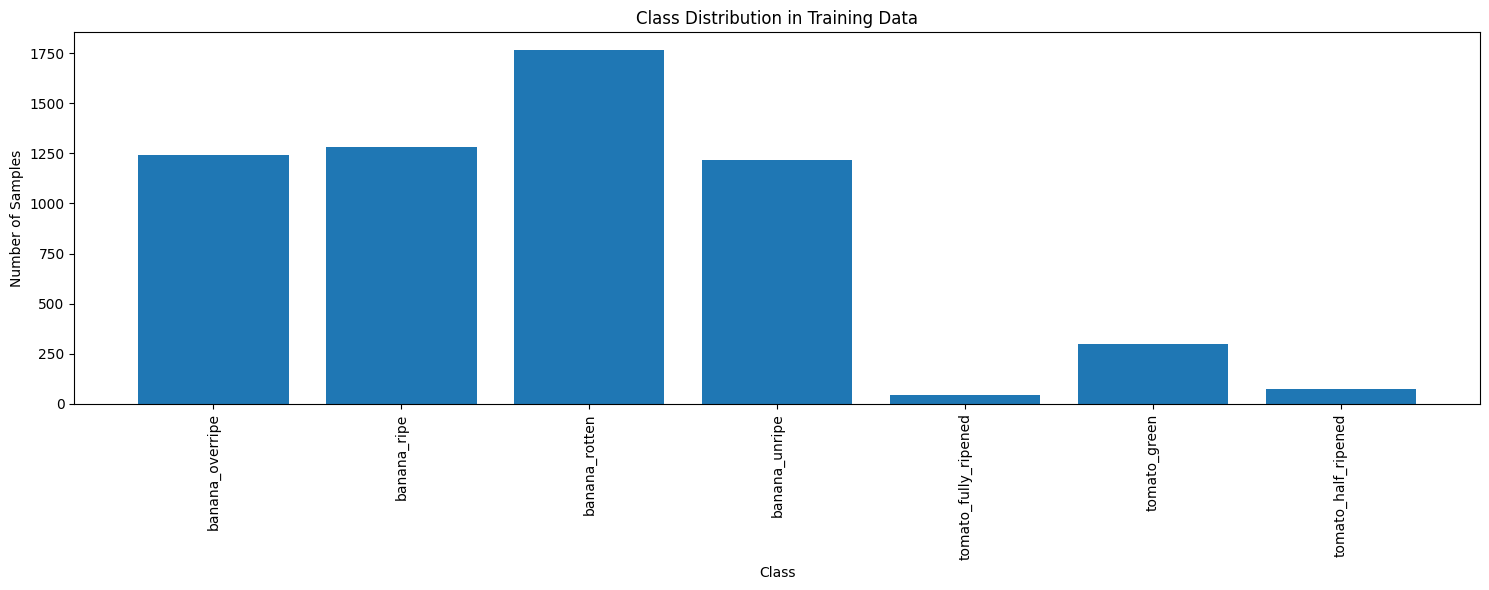

Class distribution:
banana_overripe: 1240 samples
banana_ripe: 1280 samples
banana_rotten: 1766 samples
banana_unripe: 1218 samples
tomato_fully_ripened: 44 samples
tomato_green: 297 samples
tomato_half_ripened: 72 samples
Imbalance ratio (max/min): 40.14


In [26]:
# Analyze class distribution
print("\nAnalyzing class distribution...")
labels, counts = analyze_class_distribution(trainData)

In [27]:
# Calculate class weights to handle imbalanced data
print("\nCalculating class weights...")
class_weights = calculate_class_weights(trainData)
print("Class weights:", class_weights)


Calculating class weights...
Class weights: {0: 0.6816820276497696, 1: 0.6603794642857143, 2: 0.4786442323248665, 3: 0.6939948393150364, 4: 19.211038961038962, 5: 2.846079846079846, 6: 11.740079365079366}


In [28]:
# Create the Vision Transformer model
print("\nCreating Vision Transformer model...")
NUM_CLASSES = len(trainData.class_indices)
INPUT_SHAPE = (*IMG_SIZE, 3)

model = create_vit_model(
    input_shape=INPUT_SHAPE,
    patch_size=16,
    num_classes=NUM_CLASSES,
    projection_dim=128,
    num_heads=8,
    transformer_layers=8,
    mlp_head_units=[2048, 1024],
    dropout=0.1
)

# Print model summary
print("\nModel Summary:")
model.summary()


Creating Vision Transformer model...

Model Summary:


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_creation_5 (PatchCreation)     │ (None, None, 768)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_5 (PatchEmbedding)   │ (None, None, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ position_embedding_5                 │ (None, 196, 128)            │          25,088 │
│ (PositionEmbedding)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 196, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_8          │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_9          │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_10         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_11         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_12         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_13         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_14         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_15         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_101              │ (None, 196, 128)            │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 2048)                │         264,1

 Total params: 7,771,015 (29.64 MB)

 Trainable params: 7,771,015 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
print("\nStarting training...")
history = compile_and_train_model(
    model=model,
    train_data=trainData,
    val_data=valData,
    class_weights=class_weights,
    epochs=EPOCHS
)


Starting training...
Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.1874 - loss: 1.9036
Epoch 1: val_accuracy improved from -inf to 0.30108, saving model to best_vit_model.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 223s 858ms/step - accuracy: 0.1877 - loss: 1.9025 - val_accuracy: 0.3011 - val_loss: 1.6019 - learning_rate: 1.0000e-04
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.4259 - loss: 1.3110
Epoch 2: val_accuracy improved from 0.30108 to 0.63599, saving model to best_vit_model.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 147s 769ms/step - accuracy: 0.4265 - loss: 1.3101 - val_accuracy: 0.6360 - val_loss: 1.0444 - learning_rate: 1.0000e-04
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6659 - loss: 1.0002
Epoch 3: val_accuracy improved from 0.63599 to 0.69959, saving model to best_vit_model.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 133s 695ms/step - accuracy: 0.6661 - loss: 0.9995 - val_accuracy: 0.6996 - val_loss: 0.6624 - learning_rate: 1.

In [ ]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Evaluate the model
print("\nEvaluating model...")
val_loss, val_accuracy = evaluate_model(model, valData)

# Load the best model weights
print("\nLoading best model weights...")
model.load_weights('best_vit_model.keras')

# Create submission file
print("\nCreating submission file...")
submission_df = create_submission_csv(model, testData, 'submission.csv')

# Save model architecture and weights separately for easy loading later
print("\nSaving model for future use...")
model.save('fruit_quality_vit_complete.keras')

# Save class indices for future reference
import json
class_indices = trainData.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("\nTraining completed successfully!")
print(f"Final validation accuracy: {val_accuracy:.4f}")
print("Files saved:")
print("- best_vit_model.keras (best model weights)")
print("- fruit_quality_vit_complete.keras (complete model)")
print("- submission.csv (Kaggle submission)")
print("- class_indices.json (class mappings)")

# Additional metrics and visualization
print("\nGetting final predictions on validation set...")
val_predictions = model.predict(valData, verbose=1)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Get actual labels for validation set
val_labels = []
for i in range(len(valData)):
    batch_x, batch_y = valData[i]
    val_labels.extend(batch_y)
valData.reset()

val_labels = np.array(val_labels[:len(val_predicted_classes)])

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
class_names = list(trainData.class_indices.keys())

print("\nClassification Report:")
print(classification_report(val_labels, val_predicted_classes, target_names=class_names))

# Confusion matrix
print("\nCreating confusion matrix...")
cm = confusion_matrix(val_labels, val_predicted_classes)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add numbers to confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
"""
Exam Day Prediction Script
This script loads the trained model and generates predictions for the test samples
Run this script on exam day with the test data
"""

import tensorflow as tf
import numpy as np
import pandas as pd
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

# Custom layer imports (needed for loading the model)
from vit_tensorflow_complete import (
    PatchCreation, 
    PatchEmbedding, 
    PositionEmbedding, 
    TransformerEncoderBlock
)

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_trained_model(model_path):
    """Load the trained Vision Transformer model"""
    # Define custom objects for loading
    custom_objects = {
        'PatchCreation': PatchCreation,
        'PatchEmbedding': PatchEmbedding, 
        'PositionEmbedding': PositionEmbedding,
        'TransformerEncoderBlock': TransformerEncoderBlock
    }
    
    print(f"Loading model from {model_path}...")
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
    return model

def prepare_test_data(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """Prepare test data for prediction"""
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,  # No labels
        shuffle=False     # Keep order for submission
    )
    
    return test_generator

def make_predictions(model, test_generator, class_indices_path='class_indices.json'):
    """Generate predictions and create submission file"""
    print("Making predictions...")
    
    # Load class indices
    with open(class_indices_path, 'r') as f:
        class_indices = json.load(f)
    
    # Invert class_indices to get index -> class_name mapping
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Generate predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get filenames and extract IDs
    filenames = test_generator.filenames
    ids = [os.path.splitext(os.path.basename(f))[0] for f in filenames]
    
    # Map predictions to class names
    predicted_labels = [idx_to_class[pred] for pred in predicted_classes]
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': ids,
        'label': predicted_labels
    })
    
    return submission_df

def main(test_dir, model_path='best_vit_model.keras', output_file='exam_submission.csv'):
    """Main function to run predictions"""
    print("=== Exam Day Prediction Script ===")
    print(f"Test directory: {test_dir}")
    print(f"Model path: {model_path}")
    print(f"Output file: {output_file}")
    
    # Load model
    model = load_trained_model(model_path)
    
    # Prepare test data
    test_generator = prepare_test_data(test_dir)
    print(f"Found {test_generator.samples} test samples")
    
    # Make predictions
    submission_df = make_predictions(model, test_generator)
    
    # Save submission
    submission_df.to_csv(output_file, index=False)
    print(f"\nSubmission saved to {output_file}")
    
    # Show sample predictions
    print("\nSample predictions:")
    print(submission_df.head(10))
    
    # Show class distribution in predictions
    print("\nPredicted class distribution:")
    print(submission_df['label'].value_counts())
    
    return submission_df

# Example usage
if __name__ == "__main__":
    # Update these paths for your specific setup
    TEST_DIR = '/path/to/exam/test/data'  # Update this path
    MODEL_PATH = 'best_vit_model.keras'
    OUTPUT_FILE = 'exam_submission.csv'
    
    # Run predictions
    submission = main(TEST_DIR, MODEL_PATH, OUTPUT_FILE)

# Alternative: Quick prediction script for different model formats
def quick_predict(test_dir, model_path):
    """Quick prediction function that handles different model formats"""
    try:
        # Try loading with custom objects first
        model = load_trained_model(model_path)
    except:
        try:
            # Try loading as SavedModel
            print("Trying to load as SavedModel...")
            model = tf.keras.models.load_model(model_path)
        except:
            # Try loading weights only
            print("Trying to load weights only...")
            # You would need to recreate the model architecture here
            # model = create_vit_model(...)  # Uncomment and provide parameters
            # model.load_weights(model_path)
            raise ValueError("Could not load model. Please check the model path.")
    
    # Prepare data and make predictions
    test_gen = prepare_test_data(test_dir)
    submission = make_predictions(model, test_gen)
    
    return submission

# Debugging functions
def verify_model_loading(model_path):
    """Verify that the model can be loaded properly"""
    try:
        model = load_trained_model(model_path)
        print("✓ Model loaded successfully")
        print(f"Model input shape: {model.input_shape}")
        print(f"Model output shape: {model.output_shape}")
        return True
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return False

def test_prediction_pipeline(test_dir, model_path, n_samples=5):
    """Test the prediction pipeline with a small subset"""
    print("Testing prediction pipeline...")
    
    # Load model
    model = load_trained_model(model_path)
    
    # Create test generator with small batch
    test_gen = prepare_test_data(test_dir, batch_size=n_samples)
    
    # Get one batch
    test_batch = next(test_gen)
    
    # Make prediction
    pred = model.predict(test_batch)
    print(f"Prediction shape: {pred.shape}")
    print(f"Sample prediction: {pred[0]}")
    
    return pred